In [ ]:
pip install pyarrow geoarrow-pyarrow geopandas earthaccess==0.9.0 jupyterlab_vim

In [23]:
import h5py
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import geoarrow.pyarrow as ga
from geoarrow.pyarrow import io
import geopandas as gpd
import numpy as np
import shapely
from datetime import datetime, timezone, timedelta

import json
import earthaccess
from earthaccess.results import DataGranule
from earthaccess.search import DataGranules
import fsspec
import os
import calendar
import time
import numpy as np
import concurrent

In [24]:
def result_bbox(result: DataGranule):
    points = result["umm"]["SpatialExtent"]["HorizontalSpatialDomain"]["Geometry"]["GPolygons"][0]["Boundary"]["Points"]

    longitudes = [point['Longitude'] for point in points]
    latitudes = [point['Latitude'] for point in points]

    min_lon, min_lat = min(longitudes), min(latitudes)
    max_lon, max_lat = max(longitudes), max(latitudes)
    bbox = shapely.geometry.box(min_lon, min_lat, max_lon, max_lat)
    return bbox

In [25]:
def results_bounds(results: list[DataGranule]):
    union_bbox = result_bbox(results[0])
    for result in results:
        bbox = result_bbox(result)  
        union_bbox = union_bbox.union(bbox)
    return list(union_bbox.envelope.bounds)

In [26]:
geo_metadata = {
    "columns": {
        "geometry": {
            "bbox": [
                -180.0,
                -90.0,
                180.0,
                83.6451
            ],
            "covering": {
                "bbox": {
                    "xmax": [
                        "bbox",
                        "xmax"
                    ],
                    "xmin": [
                        "bbox",
                        "xmin"
                    ],
                    "ymax": [
                        "bbox",
                        "ymax"
                    ],
                    "ymin": [
                        "bbox",
                        "ymin"
                    ]
                }
            },
            "crs": {
                "$schema": "https://proj.org/schemas/v0.6/projjson.schema.json",
                "area": "World.",
                "bbox": {
                    "east_longitude": 180,
                    "north_latitude": 90,
                    "south_latitude": -90,
                    "west_longitude": -180
                },
                "coordinate_system": {
                    "axis": [
                        {
                            "abbreviation": "Lon",
                            "direction": "east",
                            "name": "Geodetic longitude",
                            "unit": "degree"
                        },
                        {
                            "abbreviation": "Lat",
                            "direction": "north",
                            "name": "Geodetic latitude",
                            "unit": "degree"
                        }
                    ],
                    "subtype": "ellipsoidal"
                },
                "datum_ensemble": {
                    "accuracy": "2.0",
                    "ellipsoid": {
                        "inverse_flattening": 298.257223563,
                        "name": "WGS 84",
                        "semi_major_axis": 6378137
                    },
                    "id": {
                        "authority": "EPSG",
                        "code": 6326
                    },
                    "members": [
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1166
                            },
                            "name": "World Geodetic System 1984 (Transit)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1152
                            },
                            "name": "World Geodetic System 1984 (G730)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1153
                            },
                            "name": "World Geodetic System 1984 (G873)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1154
                            },
                            "name": "World Geodetic System 1984 (G1150)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1155
                            },
                            "name": "World Geodetic System 1984 (G1674)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1156
                            },
                            "name": "World Geodetic System 1984 (G1762)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1309
                            },
                            "name": "World Geodetic System 1984 (G2139)"
                        }
                    ],
                    "name": "World Geodetic System 1984 ensemble"
                },
                "id": {
                    "authority": "OGC",
                    "code": "CRS84"
                },
                "name": "WGS 84 (CRS84)",
                "scope": "Not known.",
                "type": "GeographicCRS"
            },
            "edges": "planar",
            "encoding": "WKB",
            "geometry_types": [
                "Point",
            ]
        }
    },
    "primary_column": "geometry",
    "version": "1.1.0-dev"
}

In [27]:
def datasets_to_fields(group: h5py.Group):
    fields = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            dtype = group[key].dtype
            numpy_dtype = dtype.newbyteorder("=")
            arrow_type = pa.from_numpy_dtype(numpy_dtype)
            fields.append((key, arrow_type))
    return fields

In [52]:
def create_pyarrow_schema(template_file: h5py.File, geo_metadata: dict) -> pa.schema:
    land_segments_group = template_file["gt1l"]["land_segments"]
    canopy_group = template_file["gt1l"]["land_segments"]["canopy"]
    terrain_group = template_file["gt1l"]["land_segments"]["terrain"]  
    
    land_segment_fields = datasets_to_fields(land_segments_group)
    geometry_field = pa.field("geometry", pa.binary(), metadata={
        "encoding": "WKB",
        "geometry_types": "POINT"
    })
    land_segment_fields.append(geometry_field)
    
    timestamp_field = pa.field("timestamp", pa.timestamp('ns'))
    land_segment_fields.append(timestamp_field)
    
    beam_field = pa.field("beam", pa.string())
    land_segment_fields.append(beam_field) 
    
    strength_field = pa.field("strength", pa.string())
    land_segment_fields.append(strength_field) 
    
    
    canopy_fields = datasets_to_fields(canopy_group)
    terrain_fields = datasets_to_fields(terrain_group)

    fields = land_segment_fields + canopy_fields + terrain_fields

    metadata = json.dumps(geo_metadata).encode('utf-8')
    schema = pa.schema(fields, metadata={b"geo": metadata})
    
    return schema

In [53]:
def get_group_chunks(group: h5py.Group, offset: int, chunk_size: int) -> list[np.array]:
    chunks = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            if len(group[key].chunks) == 1:
                chunks.append(group[key][offset:offset+chunk_size])
            # Handle variables with land segment chunking
            elif len(group[key].chunks) == 2:
                chunks.append(group[key][offset:offset+chunk_size, 0])
    return chunks

In [59]:
def chunks_to_tables(result: DataGranule, fs, schema: pa.schema, beam: str):
    tables = []
    url = result.data_links(access="direct")[0]
    print(url)
    with fs.open(url, 'rb') as f:
        file = h5py.File(f)
        orientation = file['orbit_info']['sc_orient'][0]
        if orientation == 0 and beam[-1] == "l":
            strength = "strong"
        elif orientation == 1 and beam[-1] == "r":
            strength = "strong"
        elif orientation == 2:
            strength = "degraded"
        else:
            strength = "weak"

        GPS_EPOCH = pd.to_datetime('1980-01-06 00:00:00')
        # Not sure why other examples of this were using the value as an array
        atlas_sdp_gps_epoch = file['ancillary_data']['atlas_sdp_gps_epoch'][0]
        
        land_segments_group = file[beam]["land_segments"]
        canopy_group = file[beam]["land_segments"]["canopy"]
        terrain_group = file[beam]["land_segments"]["terrain"] 

        chunk_size = land_segments_group["latitude"].chunks[0]
        size = land_segments_group["latitude"].size
        number_of_chunks = (size // chunk_size) + 1
    
        for n in range(number_of_chunks):
            offset = n * chunk_size
            land_segment_chunks = get_group_chunks(land_segments_group, offset, chunk_size)
            # Populate geometry field
            geometries = []
            for lat, lon in zip(
                land_segments_group["latitude"][offset:offset+chunk_size],
                land_segments_group["longitude"][offset:offset+chunk_size]
            ):
                point = shapely.Point(lon, lat)
                point_wkb = shapely.to_wkb(point, flavor="iso")
                geometries.append(point_wkb)
            land_segment_chunks.append(geometries)

            # Important to note that array order append order needs to be the same as the schema fields order.
            timestamps = []
            for delta_time in land_segments_group["delta_time"][offset:offset+chunk_size]:
                timestamp = GPS_EPOCH + pd.to_timedelta(delta_time+atlas_sdp_gps_epoch, unit='s')
                timestamps.append(timestamp)
            land_segment_chunks.append(timestamps)

            # Add fixed values 
            beam_values = [beam] * len(geometries)
            land_segment_chunks.append(beam_values)
            strength_values = [strength] * len(geometries)
            land_segment_chunks.append(strength_values)
            
            canopy_chunks = get_group_chunks(canopy_group, offset, chunk_size)
            terrain_chunks = get_group_chunks(terrain_group, offset, chunk_size)
            chunks = land_segment_chunks + canopy_chunks + terrain_chunks
            table = pa.Table.from_arrays(chunks, schema=schema)   
            tables.append(table)
    return tables

In [31]:
def update_schema_geo_metadata(results: list[DataGranule], schema: pa.schema, geo_metadata: dict) -> pa.schema:
    bounds = results_bounds(results)
    metadata = schema.metadata.copy()
    geo_metadata["columns"]["geometry"]["bbox"] = bounds
    metadata[b"geo"] = json.dumps(geo_metadata).encode('utf-8')
    updated_schema = schema.with_metadata(metadata)
    return updated_schema

In [32]:
def write_results_by_group(results_list: list[DataGranule], num_files_per_group: int, fs, schema: pa.schema, geo_metadata: dict, file_name):
    results_schema = update_schema_geo_metadata(results_list, schema, geo_metadata)
    table_writer = pq.ParquetWriter(file_name, results_schema)
    for i in range(0, len(results_list), num_files_per_group):
        print(i)
        results_group = results_list[i:i+num_files_per_group]
        results_group_schema = update_schema_geo_metadata(results_group, schema, geo_metadata)
        beams = ["gt1l", "gt1r", "gt2l", "gt2r"]
        for beam in beams:
            results_group_tables = []
            with concurrent.futures.ThreadPoolExecutor() as executor:
                futures = [executor.submit(chunks_to_tables, result, fs, results_group_schema, beam) for result in results_group]
                completed_futures, _ = concurrent.futures.wait(futures) 
                for future in completed_futures:
                    try:
                        results_group_tables.extend(future.result())
                    except Exception as exception:
                        print(exception) 
                 
                combined_table = pa.concat_tables(results_group_tables)
                table_writer.write_table(combined_table)
    table_writer.close()

In [5]:
start = datetime(2021, 10, 1, tzinfo=timezone.utc)
#next_month_days = calendar.monthrange(start.year, start.month + 1)[1]
end = start + timedelta(days=7)

results = earthaccess.search_data(
    short_name="ATL08",
    cloud_hosted=True,
    temporal=(start, end),
    count=-1
)
year_month = f"year={start.year}/month={start.month}"
week = 0
len(results)

Granules found: 1064


1064

In [6]:
sorted_results = sorted(results, key=lambda r : datetime.strptime(r['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'], '%Y-%m-%dT%H:%M:%S.%fZ'))

In [7]:
s3 = fsspec.filesystem('s3')

In [8]:
f = s3.open(results[0].data_links(access="direct")[0], 'rb')
file = h5py.File(f)
file

<HDF5 file "ATL08_20211001000125_01301310_006_01.h5>" (mode r)>

In [55]:
template_schema = create_pyarrow_schema(file, geo_metadata)

In [56]:
results_subset = sorted_results[0:1]

In [57]:
partition = f"atl08_parquet/{year_month}"
os.makedirs(partition, exist_ok=True)
file_name = f"{partition}/{week}.parquet"
write_results_by_group(results_subset, 10, s3, template_schema, geo_metadata, file_name)

0
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/10/01/ATL08_20211001000125_01301310_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/10/01/ATL08_20211001000125_01301310_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/10/01/ATL08_20211001000125_01301310_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/10/01/ATL08_20211001000125_01301310_006_01.h5


In [7]:
gdf = gpd.read_parquet('atl08_parquet')
gdf

,asr,atlas_pa,beam_azimuth,beam_coelev,brightness_flag,cloud_flag_atm,cloud_fold_flag,delta_time,delta_time_beg,delta_time_end,...,h_te_rh25,h_te_skew,h_te_std,h_te_uncertainty,n_te_photons,photon_rate_te,subset_te_flag,terrain_slope,year,month
0,0.011108,0.006987,1.808841,1.563810,0,4,0,1.182845e+08,1.182845e+08,1.182845e+08,...,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,0,0.000000,0,-0.067250,2021,10
1,0.011108,0.006987,1.809045,1.563809,0,4,0,1.182845e+08,1.182845e+08,1.182845e+08,...,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,0,0.000000,0,0.017216,2021,10
2,0.011108,0.006986,1.808911,1.563810,0,4,0,1.182845e+08,1.182845e+08,1.182845e+08,...,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,2,0.030769,1,-0.021384,2021,10
3,0.020991,0.006986,1.808906,1.563810,0,4,0,1.182845e+08,1.182845e+08,1.182845e+08,...,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,1,0.015625,0,0.011670,2021,10
4,0.020991,0.006986,1.808907,1.563810,0,3,0,1.182845e+08,1.182845e+08,1.182845e+08,...,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,2,0.031746,1,-0.020403,2021,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226678,0.052501,0.028705,-1.507345,1.542092,0,1,0,1.182837e+08,1.182837e+08,1.182837e+08,...,3.448589e+01,2.274317e-01,3.101762e-01,4.820522e-01,72,0.648649,1,0.004177,2021,10
226679,0.028688,0.028705,-1.507354,1.542091,0,1,0,1.182837e+08,1.182837e+08,1.182837e+08,...,3.468474e+01,2.918868e-01,2.388113e-01,3.319647e-01,105,1.050000,1,0.003263,2021,10
226680,0.058886,0.028705,-1.507334,1.542091,0,1,0,1.182837e+08,1.182837e+08,1.182837e+08,...,3.472367e+01,-6.762487e-01,2.314190e-01,6.968237e-01,50,0.735294,1,0.009576,2021,10
226681,0.058886,0.028705,-1.507317,1.542092,0,1,0,1.182837e+08,1.182837e+08,1.182837e+08,...,3.426458e+01,2.158826e-01,4.235795e-01,2.469563e-01,140,1.093750,1,-0.012084,2021,10


In [5]:
file_size_bytes = os.path.getsize('atl08_parquet/year=2021/month=10/0.parquet')

# Convert bytes to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)
file_size_mb

49.05743598937988

In [58]:
from shapely import wkb
dataset = pq.ParquetDataset("atl08_parquet", partitioning="hive", filters=[('year', '>=', 2021),
                                                     ('year', '<=', 2021),
                                                     ('month', '>=', 10),
                                                     ('month', '<=', 10),
                                                     ('strength', '==', 'weak')])
table = dataset.read(columns=["h_canopy", "geometry", "beam", "strength","timestamp"])
df = table.to_pandas()
df['geometry'] = df['geometry'].apply(wkb.loads)


gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf

,h_canopy,geometry,beam,strength,timestamp
0,3.402823e+38,POINT (-9.87750 -72.65531),gt1l,weak,2021-10-01 00:07:42.488961458
1,3.402823e+38,POINT (-9.87790 -72.65620),gt1l,weak,2021-10-01 00:07:42.503039360
2,3.402823e+38,POINT (-9.87830 -72.65707),gt1l,weak,2021-10-01 00:07:42.517150640
3,3.402823e+38,POINT (-9.87870 -72.65796),gt1l,weak,2021-10-01 00:07:42.531273365
4,3.402823e+38,POINT (-9.87911 -72.65884),gt1l,weak,2021-10-01 00:07:42.545321226
...,...,...,...,...,...
10725,3.402823e+38,POINT (-14.31484 -78.99661),gt2l,weak,2021-10-01 00:09:24.104056835
10726,3.402823e+38,POINT (-14.31575 -78.99748),gt2l,weak,2021-10-01 00:09:24.118113041
10727,3.402823e+38,POINT (-14.31666 -78.99836),gt2l,weak,2021-10-01 00:09:24.132155180
10728,3.402823e+38,POINT (-14.31756 -78.99923),gt2l,weak,2021-10-01 00:09:24.146311998


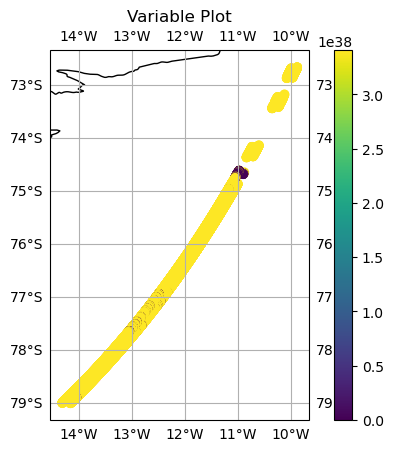

In [60]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
gdf.plot(column='h_canopy', ax=ax, legend=True, cmap='viridis')
ax.set_title('Variable Plot')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Show plot
plt.show()